In [2]:
# !pip install tsmoothie # 시계열 관측치 스무딩
# !pip install tslearn # DTW 이용한 시계열 클러스터링
# !pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 kB 5.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 10.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.5/25.5 MB 6.0 MB/s eta 0:00:0000:0100:01


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tsmoothie.smoother import *
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax
import warnings
warnings.simplefilter('ignore')

import yfinance as yf


In [28]:
df = yf.download('SPY', start='2012-06-29', end='2021-12-31')['Adj Close']
df.index = pd.to_datetime(pd.to_datetime(df.index).date)
#df = df.resample('M').last()
df = df.reset_index()
df.columns = ['timestamp', 'sp500']
df

[*********************100%***********************]  1 of 1 completed


,timestamp,sp500
0,2012-06-29,111.644012
1,2012-07-02,111.980339
2,2012-07-03,112.718590
3,2012-07-05,112.209953
4,2012-07-06,111.143578
...,...,...
2387,2021-12-23,463.087189
2388,2021-12-27,469.640869
2389,2021-12-28,469.257080
2390,2021-12-29,469.857391


In [29]:
## Smooth price series

window_shape = 20

smoother = WindowWrapper(LowessSmoother(smooth_fraction=0.6, iterations=1), window_shape=window_shape)
smoother.smooth(df['sp500'])

low, up = smoother.get_intervals('prediction_interval') # only for visualization

In [30]:
## Scale price series - raw data 

raw_scaled = TimeSeriesScalerMinMax().fit_transform(smoother.Smoother.data)
raw_scaled.shape # 몇차원

(2373, 20, 1)

In [31]:
raw_scaled

array([[[0.50098223],
        [0.58028589],
        [0.75436068],
        ...,
        [0.08705359],
        [0.51451223],
        [1.        ]],

       [[0.58028589],
        [0.75436068],
        [0.63442746],
        ...,
        [0.51451223],
        [1.        ],
        [1.        ]],

       [[0.75436068],
        [0.63442746],
        [0.3829829 ],
        ...,
        [1.        ],
        [1.        ],
        [0.81238442]],

       ...,

       [[0.17794007],
        [0.        ],
        [0.24264415],
        ...,
        [0.76497298],
        [1.        ],
        [0.98623662]],

       [[0.        ],
        [0.24077457],
        [0.10189352],
        ...,
        [0.99229494],
        [0.97863761],
        [1.        ]],

       [[0.15463762],
        [0.        ],
        [0.208645  ],
        ...,
        [0.97621397],
        [1.        ],
        [0.94853192]]])

In [32]:
## Make clusters using raw price series
## DTW(Dynamic Time Warping)

kmeans_raw = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10, random_state=123) ###
kmeans_raw.fit(raw_scaled)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=4, random_state=123)

In [34]:
kmeans_raw.cluster_centers_

array([[[0.11358756],
        [0.30898528],
        [0.30675724],
        [0.39493328],
        [0.29619934],
        [0.30459965],
        [0.29569142],
        [0.32178634],
        [0.15078717],
        [0.3239151 ],
        [0.47381133],
        [0.43464353],
        [0.62450382],
        [0.52127299],
        [0.74337264],
        [0.68214738],
        [0.86720842],
        [0.80826033],
        [0.96490662],
        [0.90205398]],

       [[0.79415933],
        [0.93597405],
        [0.81500758],
        [0.7933245 ],
        [0.60665539],
        [0.78702775],
        [0.76560832],
        [0.89931175],
        [0.79203666],
        [0.61648629],
        [0.2715252 ],
        [0.50123679],
        [0.32667457],
        [0.36320503],
        [0.07878545],
        [0.00982381],
        [0.00978585],
        [0.00987242],
        [0.038631  ],
        [0.32278636]],

       [[0.75929152],
        [0.49354657],
        [0.65689278],
        [0.81737137],
        [0.69282153],
      

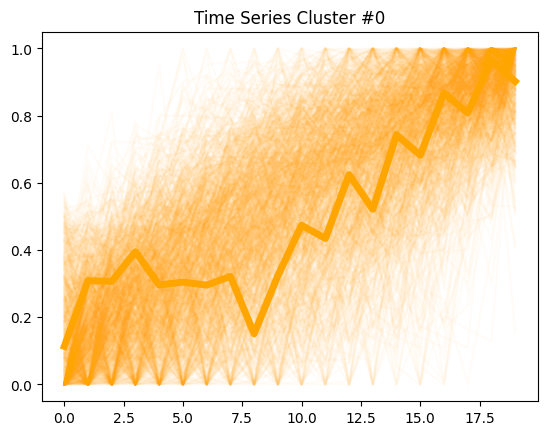

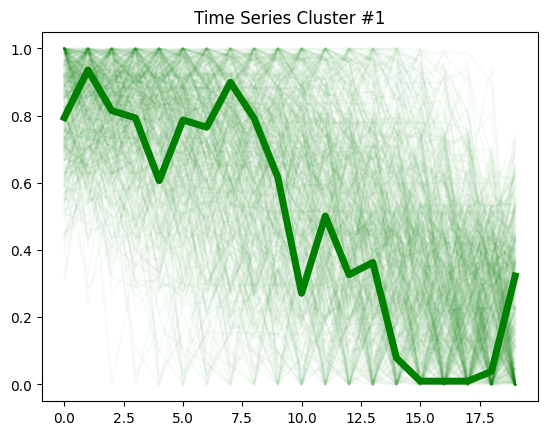

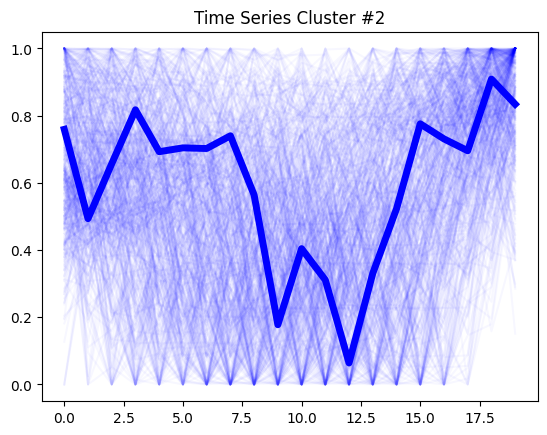

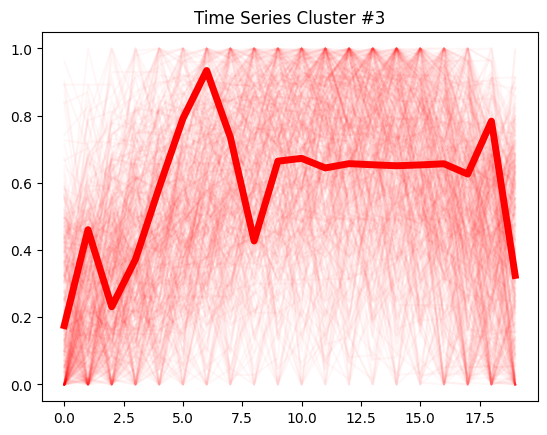

In [35]:
### Visualize price series clusters

colors = {0:'orange',1:'green',2:'blue',3:'red'}

for c in range(kmeans_raw.n_clusters):    
    plt.plot(np.squeeze(raw_scaled[kmeans_raw.labels_ == c],-1).T, c=colors[c], alpha=0.03)
    plt.plot(np.squeeze(kmeans_raw.cluster_centers_, -1)[c], c=colors[c], linewidth=5)
    plt.title(f"Time Series Cluster #{c}")
    plt.show()

In [36]:
## Make clusters using raw price series with different random seed

kmeans_raw_1234 = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10, random_state=1234) ###
kmeans_raw_1234.fit(raw_scaled)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=4, random_state=1234)

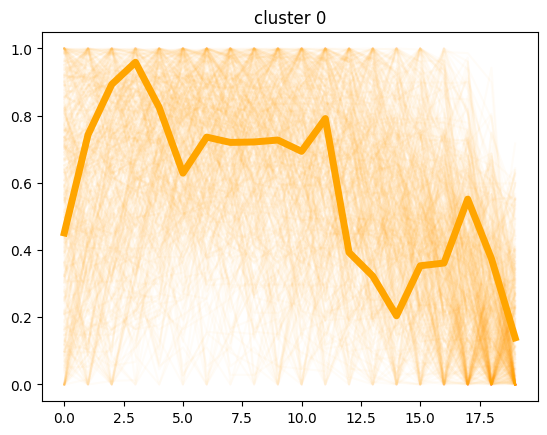

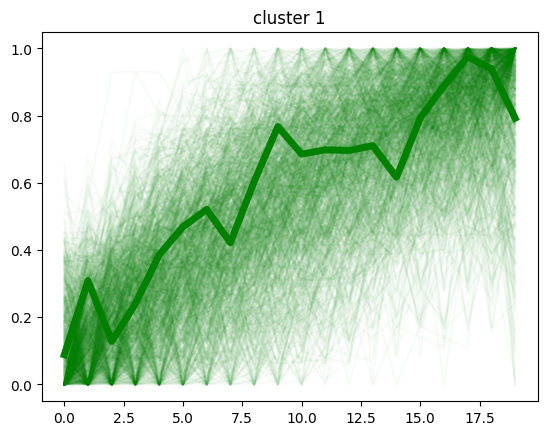

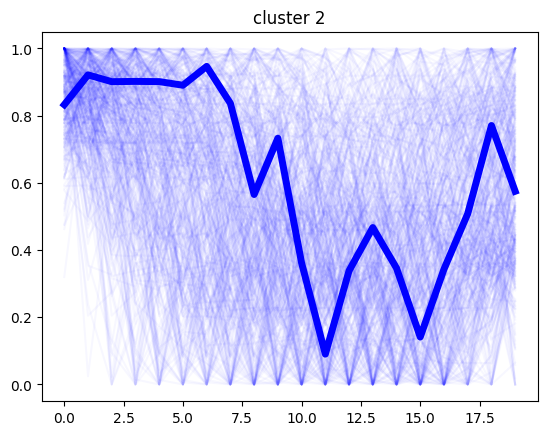

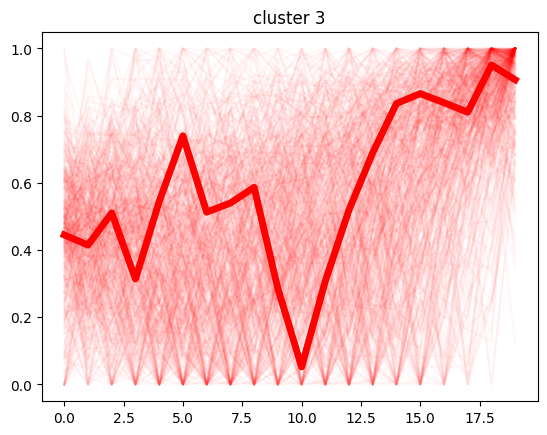

In [37]:
## Plot cluster samples

colors = {0:'orange',1:'green',2:'blue',3:'red'}

for c in range(kmeans_raw_1234.n_clusters):
    plt.plot(np.squeeze(raw_scaled[kmeans_raw_1234.labels_ == c],-1).T, c=colors[c], alpha=0.03)
    plt.plot(np.squeeze(kmeans_raw_1234.cluster_centers_, -1)[c], c=colors[c], linewidth=5)
    plt.title(f"cluster {c}")
    plt.show()

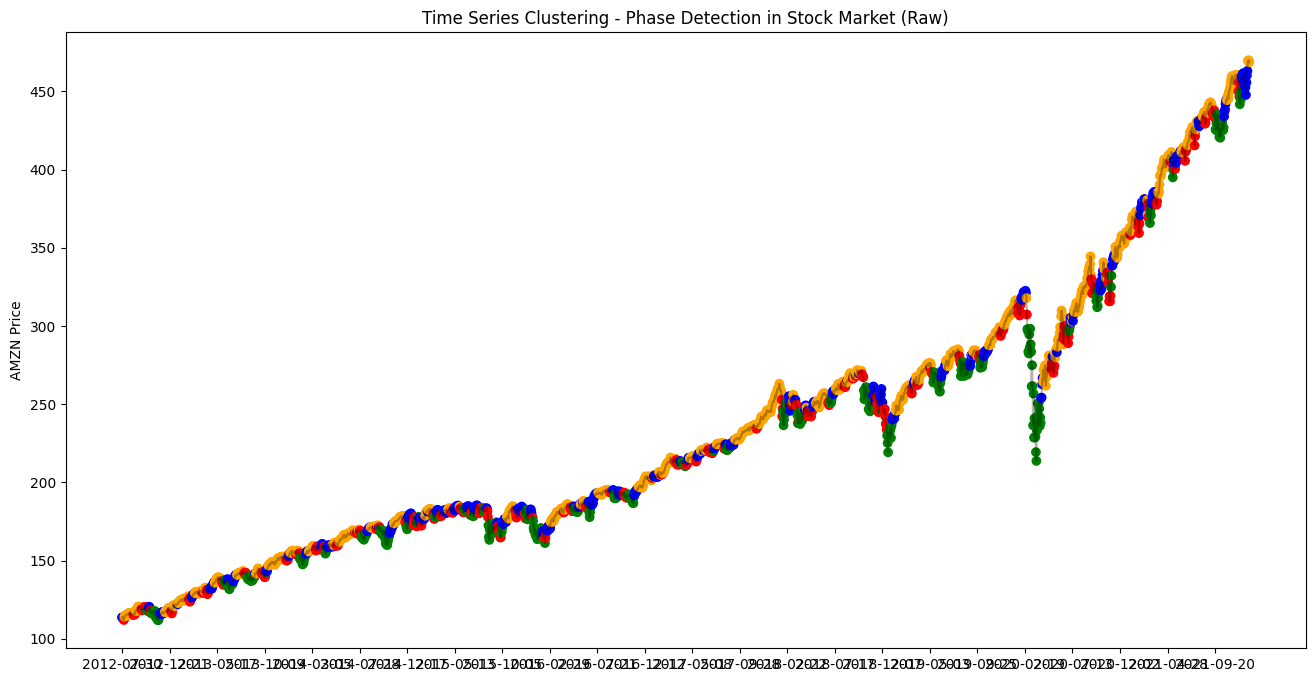

In [38]:
### Visualize price series clusters

plt.figure(figsize=(16,8))
plt.plot(smoother.Smoother.data[:,-1], c='black', alpha=0.3)
plt.scatter(range(len(smoother.Smoother.data[:,-1])), smoother.Smoother.data[:,-1], 
            c=[colors[c] for c in kmeans_raw.labels_])
plt.xticks(range(0,len(df.timestamp.unique())-window_shape, 100), 
           df.timestamp[window_shape::100].dt.date.unique())
plt.ylabel('AMZN Price')
plt.title("Time Series Clustering - Phase Detection in Stock Market (Raw)")
plt.show()

In [39]:
## LowessSmoother price series

window_shape = 20

smoother = WindowWrapper(LowessSmoother(smooth_fraction=0.6, iterations=1), window_shape=window_shape)
smoother.smooth(df['sp500'])

low, up = smoother.get_intervals('prediction_interval') # only for visualization

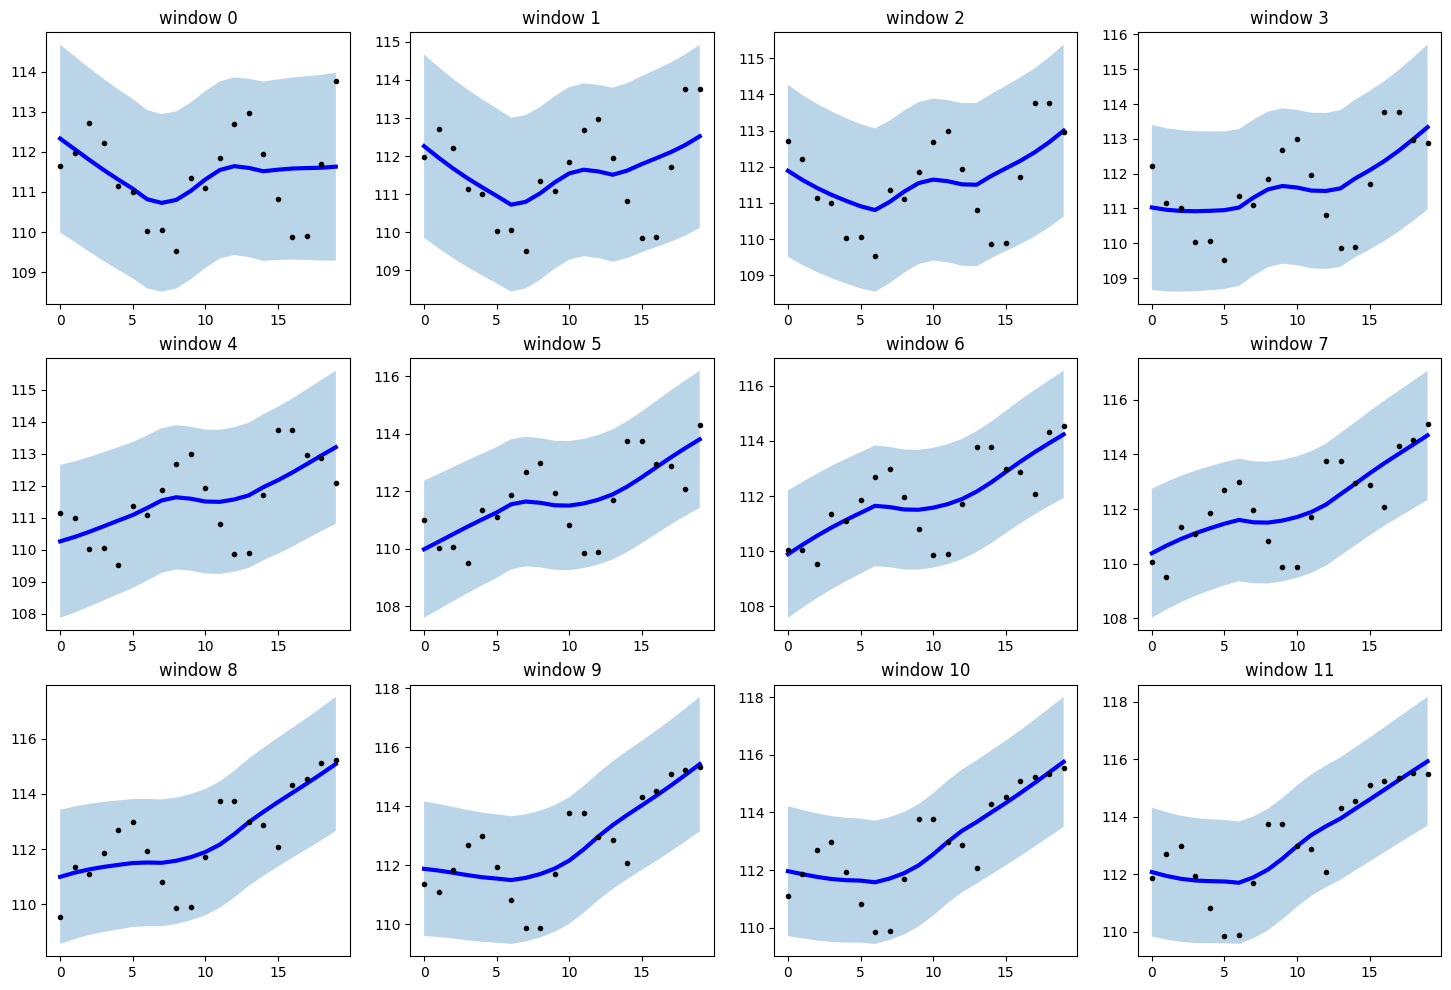

In [40]:
### Plot the first 12 smoothed windows

plt.figure(figsize=(18,12))

for i,(true,smooth) in enumerate(zip(smoother.Smoother.data, smoother.Smoother.smooth_data)):
    
    if i == 12:
        break
    
    plt.subplot(3,4, i+1)
    plt.plot(smooth, linewidth=3, color='blue')
    plt.plot(true, '.k')
    plt.fill_between(range(len(true)), low[i], up[i], alpha=0.3)
    plt.title(f"window {i}")

In [41]:
## Scale smoothed series

smooth_scaled = TimeSeriesScalerMinMax().fit_transform(smoother.Smoother.smooth_data)
smooth_scaled.shape

(2373, 20, 1)

In [42]:
## Make clusteres using smoothed series

kmeans_sm = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10, random_state=33)
kmeans_sm.fit(smooth_scaled)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=4, random_state=33)

In [47]:
len(kmeans_sm.labels_)
np.squeeze(smooth_scaled[kmeans_sm.labels_ == 0], -1).T

array([[0.04439445, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01713452, 0.04652585, 0.06797398, ..., 0.09105533, 0.09073247,
        0.07617924],
       [0.00300224, 0.10071732, 0.13741933, ..., 0.18087311, 0.1776298 ,
        0.14689864],
       ...,
       [0.71780255, 0.82063793, 0.8345004 , ..., 0.82491649, 0.81186005,
        0.798607  ],
       [0.85498349, 0.91198004, 0.91974421, ..., 0.9090416 , 0.90402048,
        0.89929255],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

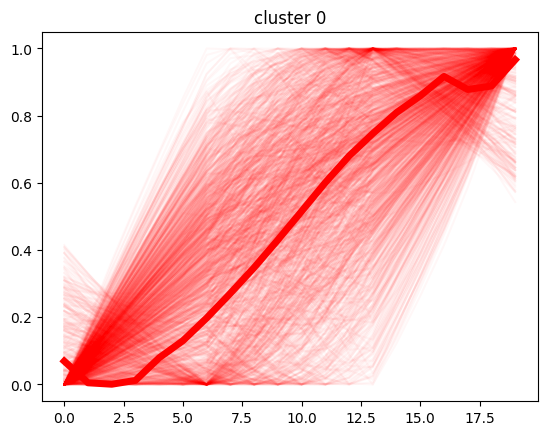

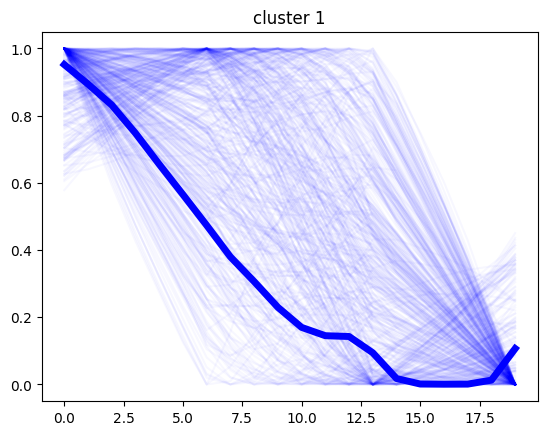

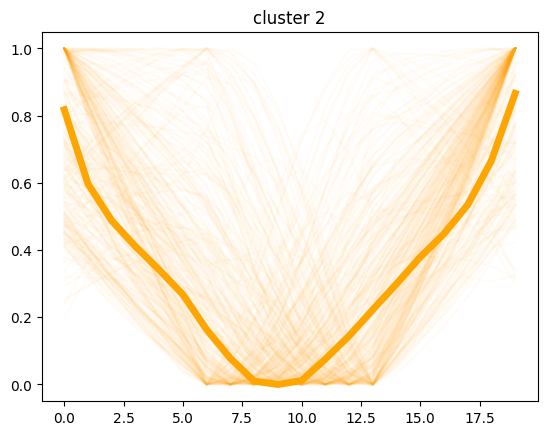

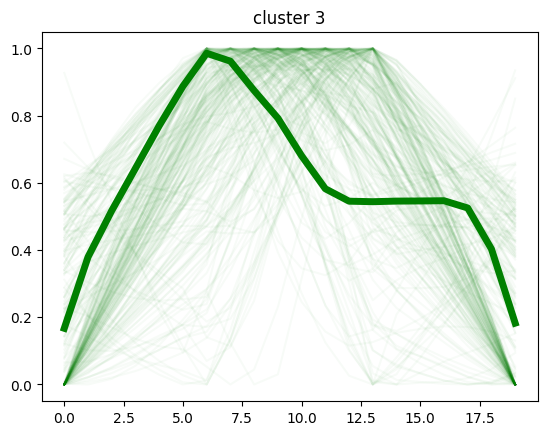

In [44]:
## Plot clusters

colors = {0:'red',1:'blue',2:'orange',3:'green', 4: 'magenta'}

for c in range(kmeans_sm.n_clusters):
    
    plt.plot(np.squeeze(smooth_scaled[kmeans_sm.labels_ == c],-1).T, c=colors[c], alpha=0.03)
    plt.plot(np.squeeze(kmeans_sm.cluster_centers_, -1)[c], c=colors[c], linewidth=5)
    plt.title(f"cluster {c}")
    
    plt.show()

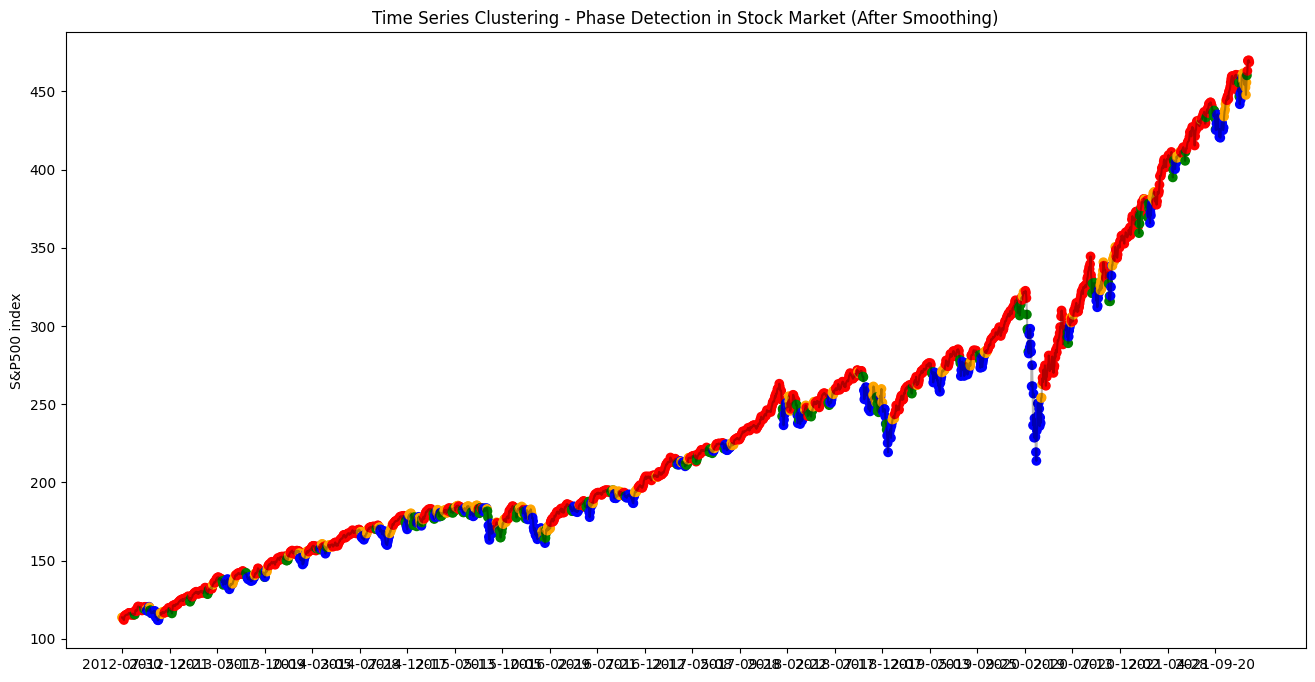

In [45]:
## Plot Clusters 

plt.figure(figsize=(16,8))

plt.plot(smoother.Smoother.data[:,-1], c='black', alpha=0.3)
plt.scatter(range(len(smoother.Smoother.data[:,-1])), smoother.Smoother.data[:,-1], 
        c=[colors[c] for c in kmeans_sm.labels_])

plt.xticks(range(0,len(df.timestamp.unique())-window_shape, 100), 
        df.timestamp.dt.date.unique()[window_shape::100])

plt.ylabel('S&P500 index')
plt.title('Time Series Clustering - Phase Detection in Stock Market (After Smoothing)')
plt.show()

    - 클러스터 별 날짜 뽑아보자

In [50]:
from tslearn.clustering import TimeSeriesKMeans

# Generate sample data
n_samples, n_features = 100, 1
data = np.random.randn(n_samples, n_features)

# Fit the model
model = TimeSeriesKMeans(n_clusters=3)
model.fit(data)

# Obtain the time index of each cluster
cluster_labels = kmeans_sm.labels_
time_index = np.arange(n_samples)

for cluster in range(model.n_clusters):
    cluster_time_index = time_index[cluster_labels == cluster]
    print(f"Cluster {cluster}: time index {cluster_time_index}")

Cluster 0: time index [ 1  2  4  5  6 11 12 13 16 18 27 29 30 32 36 40 43 48 49 52 53 54 55 58
 59 62 63 64 65 66 69 73 74 78 79 81 82 83 87 90 93 98]
Cluster 1: time index [ 3  7  9 19 21 23 31 33 34 35 42 50 51 57 61 68 70 75 76 77 80 84 85 86
 89 91 92 94 96 97 99]
Cluster 2: time index [ 0  8 10 14 15 17 20 22 24 25 26 28 37 38 39 41 44 45 46 47 56 60 67 71
 72 88 95]


In [53]:
np.arange(n_samples)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])